This notebook is meant to help getting a feeling for the fire dataset, explore promises and pitfalls, and find good pre-processing methods for the data for prediction model building.

In [1]:
# load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# load additional functions (outsourced for cleaner Notebook)
import additional_functions as af

# Data Exploration

In [2]:
# load data as dataframe
data_df = pd.read_csv('data/fires.csv')
data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


There are 3 different data types (float64, int64, object) and no missing values.

In [4]:
data_df.describe().round(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00
mean,4.67,4.30,90.64,110.87,547.94,9.02,18.89,44.29,4.02,0.02,12.85
std,2.31,1.23,5.52,64.05,248.07,4.56,5.81,16.32,1.79,0.30,63.66
min,1.00,2.00,18.70,1.10,7.90,0.00,2.20,15.00,0.40,0.00,0.00
25%,3.00,4.00,90.20,68.60,437.70,6.50,15.50,33.00,2.70,0.00,0.00
50%,4.00,4.00,91.60,108.30,664.20,8.40,19.30,42.00,4.00,0.00,0.52
75%,7.00,5.00,92.90,142.40,713.90,10.80,22.80,53.00,4.90,0.00,6.57
max,9.00,9.00,96.20,291.30,860.60,56.10,33.30,100.00,9.40,6.40,1090.84


The description for the coordinates X and Y doesn't make sense since those encompass categorical values (1-9). The attributes month and day aren't listed at all since they aren't numeric. It is therefore useful to transform the attributes X, Y, month and day into one-hot encoded attributes.

Furthermore, it seems like FFMC, DMC and DC are centered around higher values with a negative skew, and ISI, RH, rain and area are more centered around lower values. To get a better feeling of the distribution of values within attributes I will generate some plots.

First, let's check how many fires were recorded in each month and on each weekday:

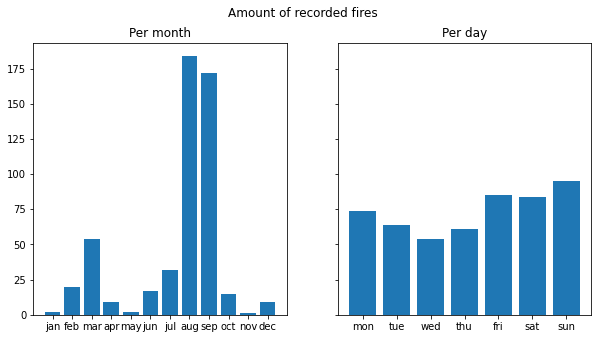

In [5]:
# datapoint distribution for months and days
# prepare data for barplot
months, days = af.get_monthsdays()
count_m = [np.sum(data_df['month']==month) for month in months]
count_d = [np.sum(data_df['day']==day) for day in days]

# plot
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
fig.suptitle('Amount of recorded fires')
axs[0].set_title('Per month')
axs[0].bar(months, count_m, align='center')
axs[1].set_title('Per day')
axs[1].bar(days, count_d, align='center')
plt.show()

As we can see on the left-hand side, by far the most fires were recorded during August and September, and there is another smaller peak in March. 

Looking at the right-hand side it seems like fires tend to occur a bit more often on weekends and weekend-adjacent days (contrast of fri-mon to tue-thu). It might make sense to combine the weekdays to more condensed features (binary weekend: yes/no; or binary weekend-adjacent: yes/no). Similarly, it might be useful to consider months in terms of calender quarters (jan-mar, apr-jun, jul-sep, oct-dec).


Now that we have seen the distribution of fire ocurrences, it is interesting to set it in relation to the severity of those recorded fires. 

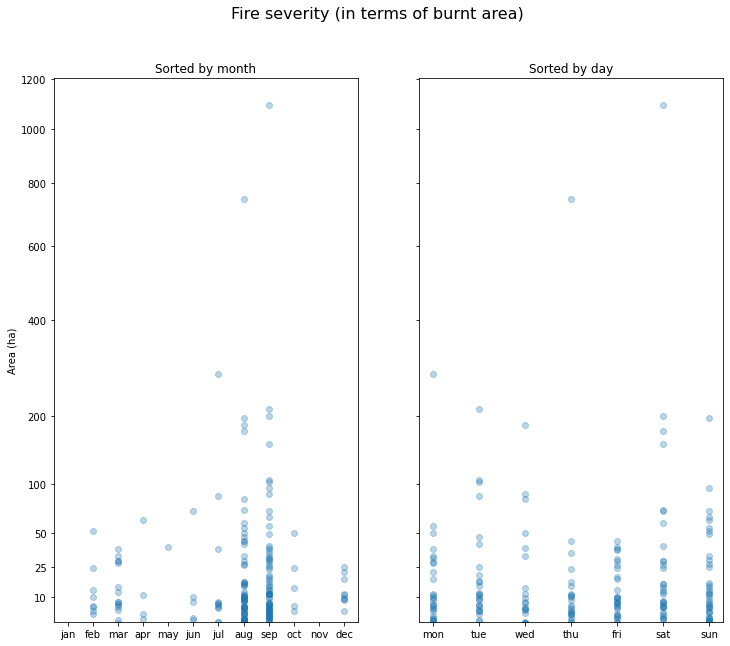

In [6]:
# burnt area sorted by month/day
fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,10))
fig.suptitle('Fire severity (in terms of burnt area)', fontsize=16)
axs[0].set_ylabel('Area (ha)')
# make y scale nicer
def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2
axs[0].set_yscale('function',functions=(forward,inverse))
axs[0].set_yticks([0,10,25,50,100,200,400,600,800,1000,1200])
#axs[0].set_yscale('logit')
# initial plot to set sorted axis label
sorthelp = axs[0].plot(months,count_m)
[s.remove() for s in sorthelp]
sorthelp = axs[1].plot(days,count_d)
[s.remove() for s in sorthelp]

# do the actual plots
axs[0].set_title('Sorted by month')
axs[0].scatter(data_df['month'], data_df['area'], alpha=0.3)
axs[1].set_title('Sorted by day')
axs[1].scatter(data_df['day'], data_df['area'], alpha=0.3)
plt.show()

As we can see on the left-hand side, most forest fires leave less than 50ha burnt. The less fire intense months seem to group more strongly below 10ha. March has a group of fires below 10ha and one group shortly over 25ha. August shows a big collection of fires in the range from 0ha to 25ha and some bigger fires above 25ha while September shows a big collection of fires in the range from 0ha to 50ha and some bigger fires above 50ha. This means that while August has more fires in total than September, fires tend to be less severe in August compared to September.

The right-hand side goes pretty much hand in hand with the distribution seen in the previous plot about recorded fires: ignoring outliers, more severe fires tend to occur on weekend-adjacent days and specifically Friday to Sunday.

Let's have a look at the distributions of the remaining attributes now:

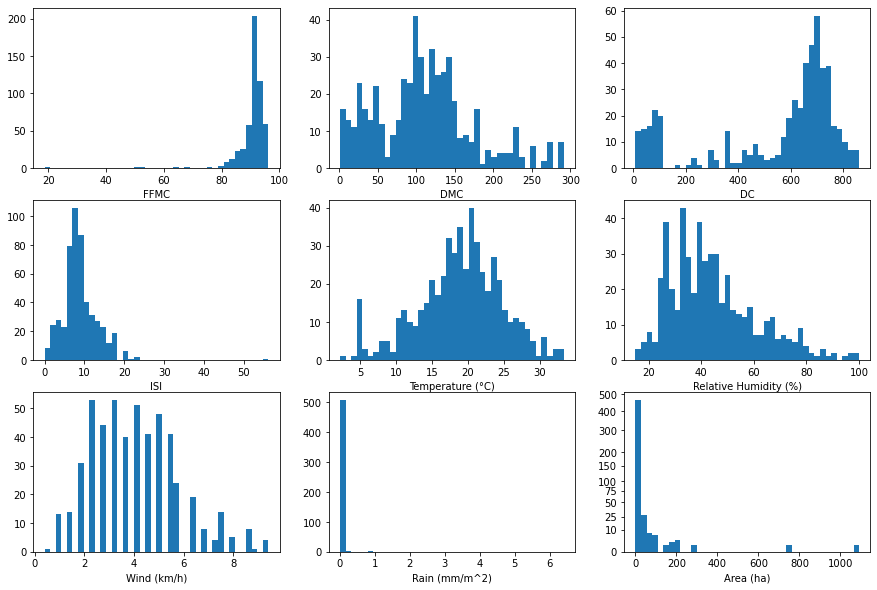

In [7]:
# view distribution of other attributes
fig, axs = plt.subplots(3,3, figsize=(15,10))
axs[0,0].hist(data_df['FFMC'], bins=40, align='mid')
axs[0,0].set_xlabel('FFMC')
# axs[0,0].set_yscale('function',functions=(forward,inverse))
# axs[0,0].set_yticks([0,10,25,50,75,100,125,150,175])
axs[0,1].hist(data_df['DMC'], bins=40, align='mid')
axs[0,1].set_xlabel('DMC')
axs[0,2].hist(data_df['DC'], bins=40, align='mid')
axs[0,2].set_xlabel('DC')
axs[1,0].hist(data_df['ISI'], bins=40, align='mid')
axs[1,0].set_xlabel('ISI')
# axs[1,0].set_yscale('function',functions=(forward,inverse))
# axs[1,0].set_yticks([0,10,25,50,60,70,80,90,100])
axs[1,1].hist(data_df['temp'], bins=40, align='mid')
axs[1,1].set_xlabel('Temperature (°C)')
axs[1,2].hist(data_df['RH'], bins=40, align='mid')
axs[1,2].set_xlabel('Relative Humidity (%)')
axs[2,0].hist(data_df['wind'], bins=40, align='mid')
axs[2,0].set_xlabel('Wind (km/h)')
axs[2,1].hist(data_df['rain'], bins=40, align='mid')
axs[2,1].set_xlabel('Rain (mm/m^2)')
axs[2,2].set_yticks([0,10,25,50,75,100,150,200,300,400,500])
axs[2,2].hist(data_df['area'], bins=40, align='mid')
axs[2,2].set_xlabel('Area (ha)')
axs[2,2].set_yscale('function',functions=(forward,inverse))
axs[2,2].set_yticks([0,10,25,50,75,100,150,200,300,400,500])
plt.show()

FFMC, DMC, and DC are all codes relating to fuel moisture indicating moisture conditions in different depths of the soil (on top of surface: FFMC; surface: DMC; deep into soil: DC). All codes are unitless, ranging from 0-101 (FFMC), 0-1000 (DC) or open-ended (DMC). All of the codes have in common that higher values represent higher levels of drought in their areas of soil; DC values near 800 already indicate extreme drought conditions (see https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system). 
The majority of fires do seem to occur with more severe drought conditions in the litter on top of the surface and in deeper soil regions, aka with higher-end extreme values of FFMC and DC, while extreme surface-level dryness (higher DMC values) does not seem to have as much of a direct co-occurrence with recorded fires.

The Initial Spread Index (ISI), a unitless and open-ended index, is a key input for fire behaviour predictions estimating a fire's spread potential (see https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system). Seeing as most recorded fires affected relatively little area (the median of fires lies at 0.52ha) it makes sense that the ISI values mostly group around relatively low values (0-20). It generally rained very little (or not at all) on days of fires and it tended to be less humid (RH mean: 44.28%, positive skew).
While the wind seems relatively normally distributed it is worth noting that even the highest velocity measured is still considered a light breeze according to the Beaufort scale (see https://www.dwd.de/DE/service/lexikon/Functions/glossar.html;jsessionid=EEA32593A7CF15894973996C90AF06D5.live21073?lv2=100310&lv3=100390).
Lastly, higher temperatures do not automatically indicate more fires; the fire count is pretty normally distributed around a mean of approximately 19°C. Of course, this says nothing regarding the relationship of temperature and fire severity.

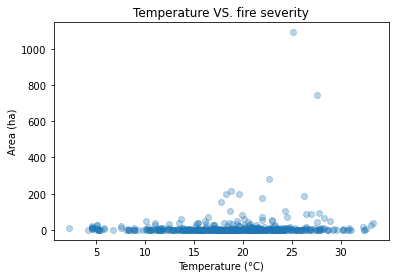

In [8]:
# temp vs area
plt.scatter(data_df['temp'], data_df['area'], alpha=0.3)
plt.title('Temperature VS. fire severity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Area (ha)')
plt.show()

While bigger fires seem to appear only when it's more than 15°C, there doesn't seem to be a clear correlation.

Let's find out whether there are areas of the forest more predestined for fires:

X coordinates:
1 : 48
2 : 73
3 : 55
4 : 91
5 : 30
6 : 86
7 : 60
8 : 61
9 : 13
Y coordinates:
2 : 44
3 : 64
4 : 203
5 : 125
6 : 74
8 : 1
9 : 6


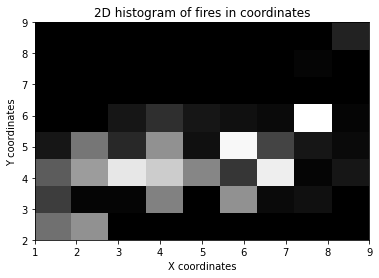

In [9]:
# count fire occurrences at specific coordinates
x_values = sorted(data_df['X'].unique())
y_values = sorted(data_df['Y'].unique())
print("X coordinates:")
for value in x_values:    
    print(value,":",sum(data_df['X']==value))
print("Y coordinates:")
for value in y_values:    
    print(value,":",sum(data_df['Y']==value))  

# plot 2D-histogram
plt.hist2d(data_df['X'],data_df['Y'], cmap=plt.cm.Greys_r, bins=(9,8))
plt.title('2D histogram of fires in coordinates')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.show()

Some coordinates and coordinate combinations are never or hardly ever affected by fires (Y: 7-9; X: 9; (3-9,2); (1-7,6); (8,2-5)). The most affected areas are (8,6), (6,5), and (7,4).

In order to find out if there are attributes that correlate most strongly with 'area', I'll have a look at a correlation heat map.

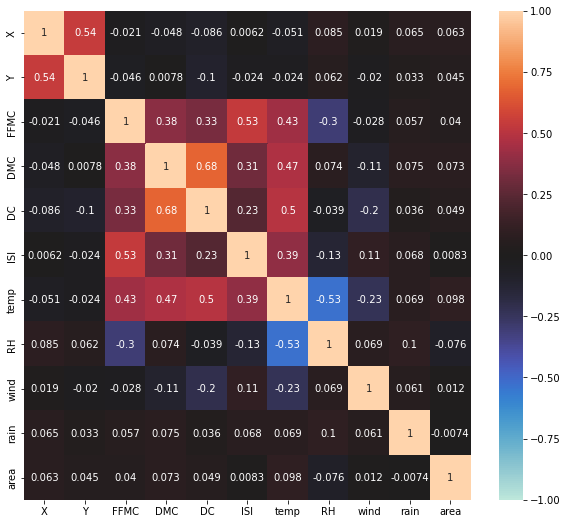

In [10]:
# correlation heat map
plt.figure(figsize=(10,9))
sns.heatmap(data_df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Somewhat unsurprisingly, the moisture codes positively correlate to some degree with each other and with temperature. ISI correlates the most with FFMC of all the moisture codes because it is also calculated based on FFMC, among others. The Relative Humidity correlates slightly negatively with FFMC and more strongly negatively with temperature, suggesting that it tends to be less humid when it's hotter and also that it is less humid when the surface forest litter is dryer. Similarly, it seems to be a little windier when the temperature is lower. None of the attributes seem to be directly correlated to the amount of area burnt in forest fires, however.

Because of their categorical nature, the coordinates, months and days are either not present in the above correlation heat map or not meaningfully dealt with. Let's bring them into the picture, too.

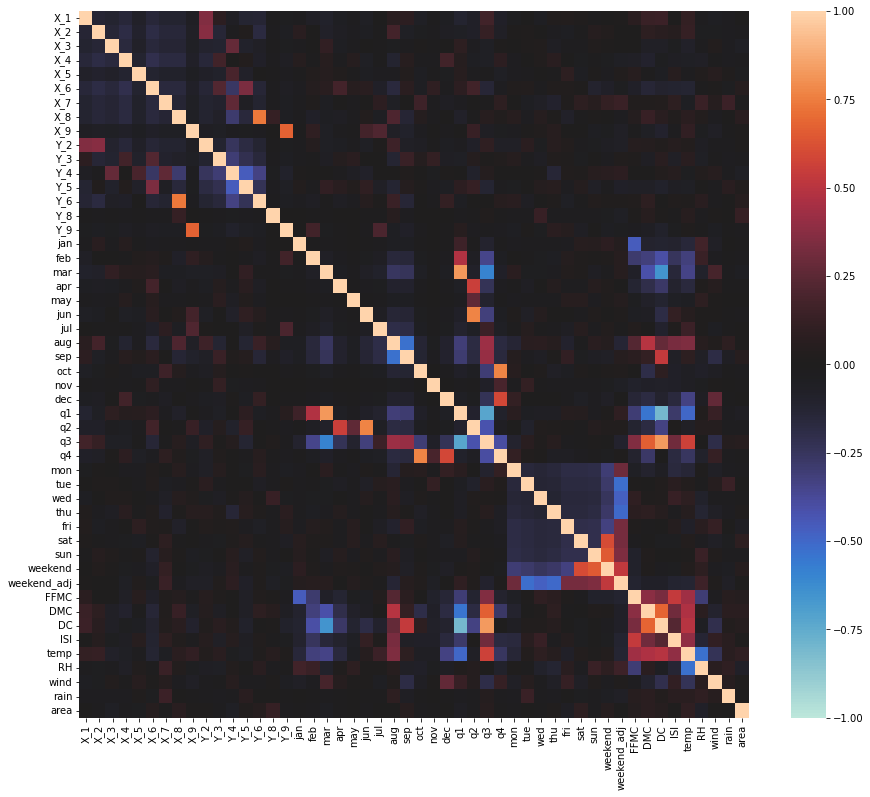

In [11]:
# make categorical attributes numeric
# one-hot encode coordinates, month, day
# condense days into binary weekend attributes and months into binary calender quarter attributes
numeric_df = af.make_numeric(data_df)

# plot exhaustive correlation heat map
plt.figure(figsize=(15,13))
sns.heatmap(numeric_df.corr(), annot=False, vmin=-1, vmax=1, center=0)
plt.show()

The correlation between the individual week days and weekend/weekend adjacent days as well as between the individual months and the calender quarters is unsurprising and obvious. It is not directly apparent which of the two weekend-based one-hot simplifications might be best, but it can be assumed that a feature reduction of this kind is useful for learning models.

An interesting aspect is that the negative correlations of jan-mar and positive correlations of aug-sep to the moisture codes, ISI and the temperature are very clearly increased when combined into calender quarters. This strengthens the idea to reduce the 12 one-hot attribute collection of 'month' into 4 calender quarters.



I will therefore use the original features (with one-hot encoded coordinates, days, and months) as a comparison to test if -- and, if yes, which of -- the engineered feature combinations (calendar quarters -- weekend // calendar quarters -- weekend adjacent) works best with all the other attributes for models learning to predict forest fire severity.

**Problematic aspects of the data:**

There are only 'snapshots' of what the situation was like on the days of a forest fire, and no sense of continuity whatsoever: The data were collected over the course of 7 years (1994-2001) but there is no information in which year each of the datapoints was collected. Also, many of the area points are 0.0.

# Data Preprocessing

The big distributions plot earlier already hinted at different kinds of distributions for different features. Let's look at the differences of value ranges:

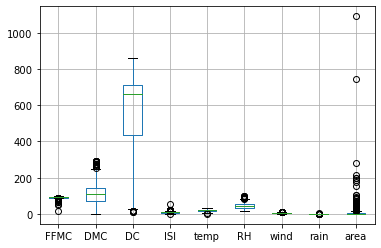

In [12]:
data_df.boxplot(column=['FFMC','DMC','DC','ISI','temp','RH','wind','rain','area']);

I don't want features with higher variances and/or scales to dominate others. I am therefore trying to find approriate techniques to apply to the data in order to make the features more or less follow a normal distribution in a somewhat similar range of values.

In [13]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
gaussian_features = ['FFMC','DMC','DC','ISI','temp','RH','wind']
log_features = ['rain','area']

# StandardScaler() calculates z-score (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
ss = StandardScaler()
# log transform according to instructions (area' = log(1+area))
lt = FunctionTransformer(np.log1p)

Let's first deal with the features that seemed to have a somewhat gaussian distribution:

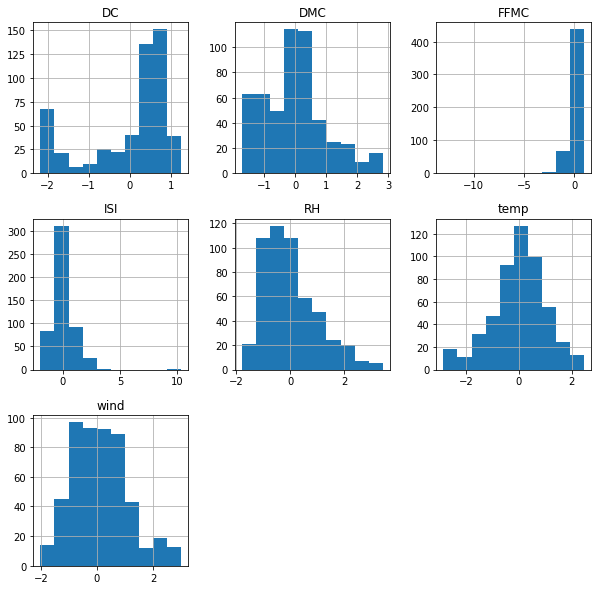

In [14]:
ss_preproc_df = pd.DataFrame(ss.fit_transform(data_df[gaussian_features]), columns=gaussian_features)
ss_preproc_df.hist(figsize=(10,10));

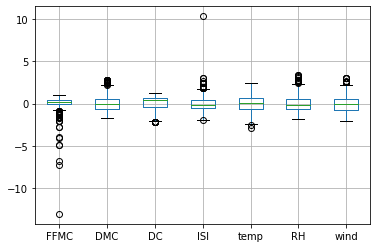

In [15]:
ss_preproc_df.boxplot();

... and now  area and rain.

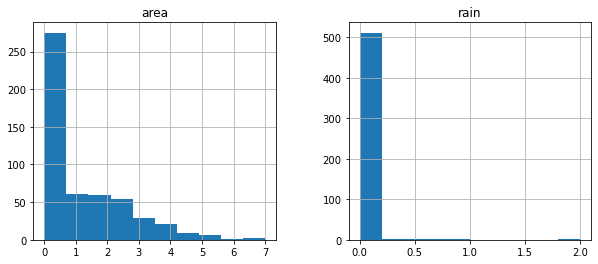

In [16]:
log_preproc_df = pd.DataFrame(lt.fit_transform(data_df[log_features]), columns=log_features)
log_preproc_df.hist(figsize=(10,4));

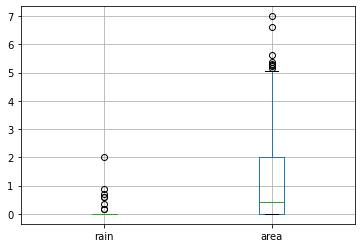

In [17]:
log_preproc_df.boxplot();

ISI has one very distinctive outlier, and FFMC is still very squished to the right side. I want to try out whether the (transformed) distribution improves if ISI's ourlier data point is removed and I define a cut-off threshold for FFMC.

In [18]:
data_df[data_df.FFMC < 80]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
12,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0.0,0.00
40,4,4,jul,tue,79.5,60.6,366.7,1.5,23.3,37,3.1,0.0,0.00
97,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0.0,0.00
130,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0.0,0.00
199,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0.0,11.32
299,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0.0,0.00
312,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0.0,0.00
379,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00
463,6,5,feb,tue,75.1,4.4,16.2,1.9,4.6,82,6.3,0.0,5.39
464,6,4,feb,tue,75.1,4.4,16.2,1.9,5.1,77,5.4,0.0,2.14


In [19]:
data_df[data_df.ISI == data_df.ISI.max()]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.0


Old length of data: 517 
New length of data: 504


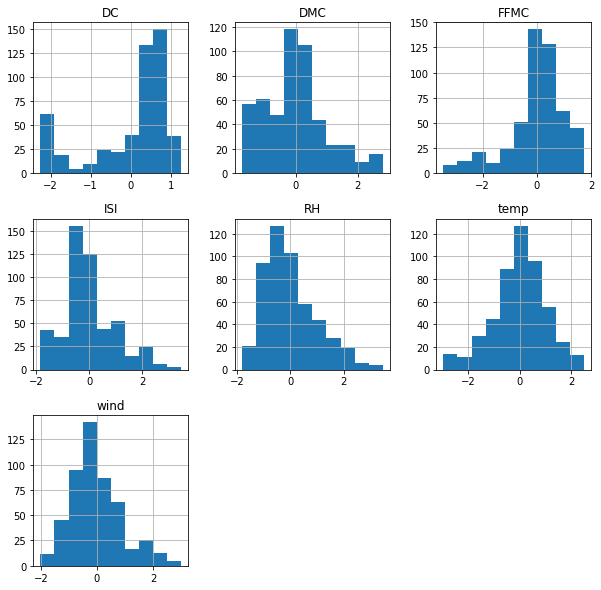

In [20]:
dropped_df = af.drop_outliers(data_df)
print("Old length of data:",len(data_df),"\nNew length of data:",len(dropped_df))
ss_dropped_df = pd.DataFrame(ss.fit_transform(dropped_df[gaussian_features]), columns=gaussian_features)
ss_dropped_df.hist(figsize=(10,10));

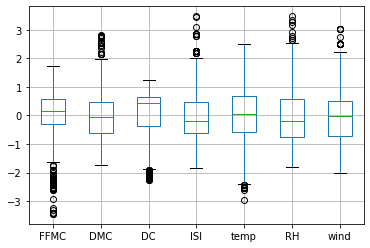

In [21]:
ss_dropped_df.boxplot();

The ISI and FFMC distributions definitely look more centered, and the distributions overall have much more similar scale ranges. I will therefore stick with not considering those 13 datapoints.